# FIT5202 - Assignment 2 

# Detecting Linux system hacking activities

Name of the student: Roma Hambar

Student ID: 31223958

Python Version Used: Python 3

## Table of Contents

* [Introduction](#Intro)
* [Data preparation and exploration](#1)
    * [Creating Spark Session](#1.1)
    * [Loading the data](#1.2)
    * [Exploring the data](#1.3)
* [Feature extraction and ML training](#2)
    * [Preparing the training data and testing data](#2.1)
    * [Preparing features, labels and models](#2.2)
    * [Training and evaluating models](#2.3)
* [Knowledge sharing](#3)

## Introduction <a class="anchor" name="Intro"></a>

Intrusion detection in Cyber Security plays a very important role in maintaining the fidelity of any IT system. In this assignment, our aim is to create a machine learning model to predict whether an activity is an attack on the system or a normal activity. We have two datasets - process activity and memory activity to design the model. Every attack activity can be predicted based on the state of the operating system at the time of the attack. 

To determine whether it is a normal process or memory activity or an attack, we will use various Linux Features recorded when CMD command on the system is executed. Depending upon the how much virtual or residential memory is being used, what kind of scheduling and priority is assigned to the process, page faults, memory released, running status etc. we can model a system to predict whether it is an attack. 

StopHacking is a startup incubated in Monash University to develop cloud service to detect and stop computer hackers from attacking any system within the organisation. To build the attack prediction machine learning model, StopHacking will identify any abnormal behaviour of the system when any command is executed. This machine learning model will be integrated with Aapache Spark and modelling using pyspark package in Python programming language.

* Datasets used:
    * Two Linux_memory datasets in csv format
    * Two Linux_process datasets in csv format
    
The Datasets used in building this model contain captured memory and process activity data recorded from Linux systems with each activity being independent of each other even if the PID (process ID is the same). 

To determine whether an activity is a noraml activity or an attack, the activity data has a binary label to indicate that the activity showed such kind of behaviour. This dataset also indicated the kind of attack the system is under.

In this assignment, we will use various pyspark libraries designed to build ML models to deal with categorical and numerical features of an activity. Two separate ML models would be designed for binary classification prediction based on whether it was a process activity or a memory activity and how the operating system behaved. Since we are interested in only determining if an attak happened, attack feature would be considered as our label for binary classification (attack = 0 indicating normal activity and attack = 1 indicating the system was attacked. 

## 1. Data preparation and exploration <a class="anchor" name="1"></a>

In any machine learning model, data preparation & exploration plays a very cruical role. Using the domain knowledge required to build the model, we can determine which features would actually contribute in accurate prediction.

### 1.1 Creating Spark Session <a class="anchor" name="1.1"></a>

To build the machine learning model for Apache Spark, let us first create a SparkConf Object with as many local cores with application name and max partition byte configuration such that each activity dataset is distributed into 4 partitions. After setting the configuration parameters, start the Spark session. To monitor all the spark jobs, you can visit the Spark UI running in your local machine.

#### 1. Create a SparkConf object with defined configuration parameters.

In [1]:
# Import SparkConf, SparkSession and SparkContext classes for Spark Session setup and Spark SQL 
# operations for further analysis
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark import SparkContext #Spark

# Run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"

# Set the name for Spark application
app_name = "Detecting Linux system hacking activities"

# Setup configuration parameters for Spark Session
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes",33554432)

#### 2. Then create a SparkSession using the SparkConf object.

In [2]:
# Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

### 1.2 Loading the data <a class="anchor" name="1.2"></a>

The next step in model building would be to load the datasets into separate dataframe according to the type of activity. Each of the process and memory activity data would be stored in pyspark dataframes.

#### 1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe.


In [3]:
# Read the memory activity data from the two csv files and read the schema of all the columns
df_memory = spark.read.format('csv')\
            .option('header',True).option('escape','"').option('inferSchema',True)\
            .load('./data/linux_memory_*.csv')

# Read the memory activity data from the two csv files and read the schema of all the columns
df_process = spark.read.format('csv')\
            .option('header',True).option('escape','"').option('inferSchema',True)\
            .load('./data/linux_process_*.csv')

In [4]:
# Print the Schema of process and memory dataframes. 
# Check the number of partitions in which the dataframes are stored and the number of rows in each dataframe
df_memory.printSchema()
print("Partitions: ",df_memory.rdd.getNumPartitions(),"and Num of rows:",df_memory.count())

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

Partitions:  4 and Num of rows: 2000000


In [5]:
df_process.printSchema()
print("Partitions: ",df_process.rdd.getNumPartitions(),"and Num of rows:",df_process.count())

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

Partitions:  4 and Num of rows: 1927968


#### 2. For each column in each dataframe above,

#### a. Check the null data (if any) and print out the corresponding count in each column

While capturing activity records, there can be activity logs without some data. We can find such columns by using search for null values in each column. In the beow code, we will count the number of null values in each column in both memory and process dataframes using the isnan() function in pyspark.sql.functions package.

In [6]:
from pyspark.sql.functions import isnan, when, count, col, regexp_replace, udf

In [7]:
df_memory.select([count(when(isnan(c), c)).alias(c) for c in df_memory.columns]).show()
df_process.select([count(when(isnan(c), c)).alias(c) for c in df_process.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



#### b. Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW','RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats

According to the metadata of process activity, 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW','RGROW' columns should be in numeric data format. But on observing the distinct values in each of these columns, it was found that 
1. some values were space separated
2. some values in range of thousands had K number format representation
3. some values in range of millions had M number format representation with single digit after decimal

Due to these errors, the number columns were converted to String format. For correct number format feature pre-extraction, we need to wrangle this data to proper numeric datatype.

In [8]:
df_memory.filter(df_memory.MINFLT.endswith('K')).show(10)

+----------+-----+------+------+------+-----+------+-----+-----+---+-------+------+------+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE| RSIZE|VGROW|RGROW|MEM|    CMD|attack|  type|
+----------+-----+------+------+------+-----+------+-----+-----+---+-------+------+------+
|1556203721|10000|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203726|10001|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203731|10002|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203741|10004|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203746|10005|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203751|10006|  132K|224.2M| 9392K|  0.0|224.2M|9392K|   0K|0.0|apache2|     0|normal|
|1556203756|10000|  132K|224.2M| 9392K|  0.0|    0K|   0K|   0K|0.0|apache2|     0|normal|
|1556204676|10137|    0K|     0|     0|  0.0|    0K|   0K|   0K|0.0| <find>|     0|normal|

In [9]:
import re
from pyspark.sql.types import IntegerType, DoubleType, StringType

In [10]:
# This UDF function will 
# 1. replace K with 3 zeros to represent numbers in proper numeric thousand values
# 2. replace values with M by first strip the decimal and then appending 5 zeroes to store the value in 
# proper millions face value.
# 3. strip off spaces between digits
# this function will return all vlaues in string format
def value_to_float(x):
    if 'K' in x:
        x = x.replace('K', '000')
    if 'M' in x:
        x = x.replace('.','')
        x = x.replace('M', '00000')
    x = x.replace(" ","")
    return x

In [11]:
# to call the above created UDF function in the pyspark sql manipulation, we will use udf() from pyspark.sql package
value_to_float_udf = udf(value_to_float)

# Wrangle the data from to rectify improper data fields
df_memory = df_memory.withColumn('MINFLT',value_to_float_udf(df_memory['MINFLT']))\
.withColumn('MAJFLT',value_to_float_udf(df_memory['MAJFLT']))\
.withColumn('VSTEXT',value_to_float_udf(df_memory['VSTEXT']))\
.withColumn('RSIZE',value_to_float_udf(df_memory['RSIZE']))\
.withColumn('VGROW',value_to_float_udf(df_memory['VGROW']))\
.withColumn('RGROW',value_to_float_udf(df_memory['RGROW']))

# COnvert the string columns to double data format as mentioned in the metadata of these activity datasets.
df_memory = df_memory.withColumn('MINFLT',col('MINFLT').cast(DoubleType()))\
.withColumn('MAJFLT',col('MAJFLT').cast(DoubleType()))\
.withColumn('VSTEXT',col('VSTEXT').cast(DoubleType()))\
.withColumn('RSIZE',col('RSIZE').cast(DoubleType()))\
.withColumn('VGROW',col('VGROW').cast(DoubleType()))\
.withColumn('RGROW',col('RGROW').cast(DoubleType()))

In [12]:
# ts = 1556203721 row has columns with all the flaws in them. 
# Check if the above manipulations have been carried out successfully
df_memory.filter(col("ts")==1556203721).show()

+----------+-----+--------+-------+---------+-----+-------+---------+-----+---+-------------+------+------+
|        ts|  PID|  MINFLT| MAJFLT|   VSTEXT|VSIZE|  RSIZE|    VGROW|RGROW|MEM|          CMD|attack|  type|
+----------+-----+--------+-------+---------+-----+-------+---------+-----+---+-------------+------+------+
|1556203721|10000|132000.0|2.242E8|9392000.0|  0.0|2.242E8|9392000.0|  0.0|0.0|      apache2|     0|normal|
|1556203721| 2837|   132.0|  281.3|  15580.0|  0.0|    0.0|      0.0|  0.0|0.0|zeitgeist-fts|     0|normal|
+----------+-----+--------+-------+---------+-----+-------+---------+-----+---+-------------+------+------+



### 1.3 Exploring the data <a class="anchor" name="1.3"></a>

Data Exploring is a practice that describes the data using both statistical and visualization techniques to feed high-quality data into the ML models. It helps in understanding what information is conveyed by each column in the dataset and amount of data that can be used to train the model. It helps in refining the selection for featuring while building the machine learning model. Data exploration should emphasize on how data leakage can be avoided while feature selection.

#### 1. Show the count of attack and non-attack in each activity based on the column “attack”, then show the count of each kind of attack in process activity based on the column “type”.
 
The below code helps in finding the count of number of attacks and non-attacks in each activity and it is found that the count is unevenly distributed amongst the two. The number of non-attack records exceeds by a huge margin than that of attack records in both memory activities and process ones. This is obvious that under normal conditions, we would witness all the activities to be performed by the users compared to intrusions by attackers. If it is a non-attack, the type of attack is categorised as 'normal'.

There are 7 types of attacks seen in the process activity - password, injection, ddos, xss, mitm, dos and scanning, with ddos (Distribued Denial of Service) attacks being the highest athe count of attack as mitm is the lowest. 

There are 5 types of attacks seen in the memory activity - password, injection, xss, mitm, dos with least mitm attacks and highest dos attacks. 

The imbalance observed in both kinds of records can be the reason for insufficient records for system under attack since the model has not been provided with enough records to learn the conditions in which the system is under attack. Also, while grouping the data based on 'attack' column, the computation cost can be too high both in terms of time and space even if the data is divided into 4 partitions. Also, since the number of negative labels (normal activity) is much greater than positive labels (attack), it can affect the accuracy calculation for the model.


In [13]:
print("Process activity Statistics:")
print("Number of attacks and non-attacks:")
df_process.groupBy(col("attack")).count().show()

print("Number of attacks and non-attacks based on type:")
df_process.groupBy(col("attack"),col("type")).count().show()

Process activity Statistics:
Number of attacks and non-attacks:
+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+

Number of attacks and non-attacks based on type:
+------+---------+-------+
|attack|     type|  count|
+------+---------+-------+
|     1| password|  51409|
|     1|injection|  41311|
|     0|   normal|1636604|
|     1|     ddos|  71603|
|     1|      xss|  17759|
|     1|     mitm|    112|
|     1|      dos|  70721|
|     1| scanning|  38449|
+------+---------+-------+



In [14]:
print("Memory activity Statistics:")
print("Number of attacks and non-attacks:")
df_memory.groupBy(col("attack")).count().show()

print("Number of attacks and non-attacks based on type:")
df_memory.groupBy(col("attack"),col("type")).count().show()

Memory activity Statistics:
Number of attacks and non-attacks:
+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+

Number of attacks and non-attacks based on type:
+------+---------+-------+
|attack|     type|  count|
+------+---------+-------+
|     1| password|  26016|
|     1|injection|  58523|
|     0|   normal|1794377|
|     1|     ddos|  45689|
|     1|     mitm|    112|
|     1|      dos|  75283|
+------+---------+-------+



#### 2. For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.

Both process and memory datasets have numeric as well as string features stored. Here would be present all the basis statistics of all the numeric columns and top-10 values of string columns excluding 'attack' (numeric) and 'type' (string) columns as these features are to be predicted by the machine learning model.  

In [15]:
# Select all numeric columns in process dataframe
num_cols_process = [f.name for f in df_process.schema.fields 
                       if isinstance(f.dataType, (IntegerType,DoubleType))
                    and f.name != 'attack']
 
# Display all the statistical values of each numeric column to find the range of the data fields
df_process.select(num_cols_process).describe().show(truncate = True)

+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|summary|                  ts|              PID|              TRUN|            TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                CPU|
+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|  count|             1927968|          1927968|           1927968|          1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|            1927968|
|   mean|1.5563198311840394E9|5068.709770597852|0.0632287465352122|3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626|    0.0|1

In [16]:
# Select all numeric columns in memory dataframe
num_cols_memory = [f.name for f in df_memory.schema.fields 
                       if isinstance(f.dataType, (IntegerType,DoubleType)) 
                  and f.name != 'attack']

# Display all the statistical values of each numeric column to find the range of the data fields
df_memory.select(num_cols_memory).describe().show(truncate = True)

+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|summary|                ts|              PID|            MINFLT|              MAJFLT|           VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|
+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+
|  count|           2000000|          2000000|           2000000|             2000000|          2000000|          2000000|           2000000|          2000000|           2000000|             2000000|
|   mean|1.55624581707609E9|      4999.360446|        983.344344|   987846.5873270865|46453.27415208986|4496.419966448755|23722.888664201997|984.4668735599995|483.17466254999994|0.003385165000001682|


In [17]:
# Select all the string columns in process dataframe
cat_cols_process = [f.name for f in df_process.schema.fields 
                       if isinstance(f.dataType, StringType) and f.name != 'type'] 

# Display the top-10 values in each string column based on frequency
for col_name in cat_cols_process:
    df_process.groupBy(col_name).count().orderBy("count", ascending=False).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [18]:
# Select all the string columns in memory dataframe
cat_cols_memory = [f.name for f in df_memory.schema.fields 
                       if isinstance(f.dataType, StringType) and f.name != 'type'] 

# Display the top-10 values in each string column based on frequency
for col_name in cat_cols_memory:
    df_memory.groupBy(col_name).count().orderBy("count", ascending=False).show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



#### 3. For each activity, present two plots worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots

In [19]:
! pip install seaborn
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

In [20]:
# Use only 70% of the each activity dataset to visualize the relation between categories
process_30,process_70 = df_process.randomSplit([0.3,0.7],seed=2020)
memory_30,memory_70 = df_memory.randomSplit([0.3,0.7],seed=2020)

We will be using Seaborn and Pandas to plot various graphs to study the relationship between different columns in the two use cases.

/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Status'>

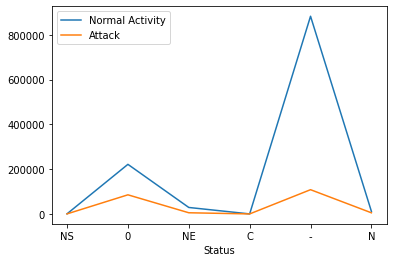

In [21]:
# Plot a graph to find the count of each Status type for both normal activity and attack
df_process_pd_0 = process_70.filter(col('attack') == 0).groupby('Status').count().withColumnRenamed('count',
                                                                                                    'Normal Activity')
df_process_pd_1 = process_70.filter(col('attack') == 1).groupby('Status').count().withColumnRenamed('count',
                                                                                                    'Attack')

# merge the two dataframes to create separate columns
df = pd.merge(df_process_pd_0.toPandas(),df_process_pd_1.toPandas())

# Plot a line graph for the two categories
df.plot(x="Status", y=["Normal Activity", "Attack"])

There are 7 types of status for any process in the sytem. This graph shows how frequently any Status type occurs for a Normal process activity and when the system is under attack. We can see '-' Status type occurs more frequently compared to the other types. This shows that some Status types were not captured. Almost no records have been recorded for new processes N , C and NS.

<AxesSubplot:xlabel='attack', ylabel='PID'>

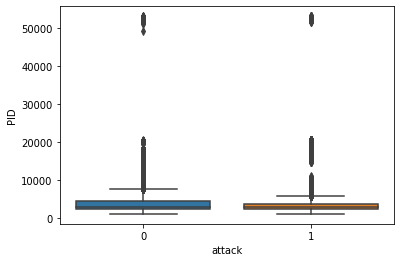

In [22]:
df_memory_pd = memory_70['PID', 'attack'].toPandas()
sns.boxplot(x='attack',y='PID',data=df_memory_pd)

The above boxplot shows how the distribution of different PIDs when the a memory activity is a normal activity or when the system is attacked. We can see that the PID values have a lot of outliers, can be well beyond a range to add noise in the model.

<AxesSubplot:>

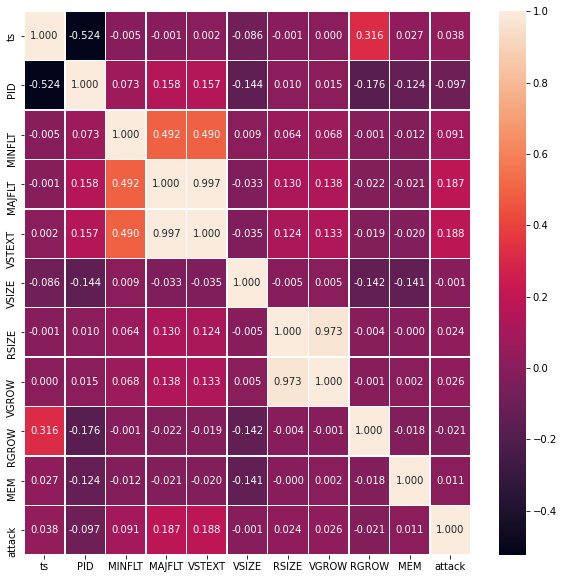

In [23]:
# correlation plot (heatmap) to show relationship between all the columns in a memory activity
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(memory_70.toPandas().corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)

The above heatmap shows the relationship between all the columns in the Process activity dataset by calculating the correlation coefficient between any two columns. From the graph, we can observe that compared to other columns, attack is less weakly correlated to MAJFLT and VSTEXT columns and has least correlation with VSIZE. Although, we know that according to the metadata, this is one of the important features. This proves that there are a lot of outliers in this data where the data ranges in millions and negative values.

<AxesSubplot:>

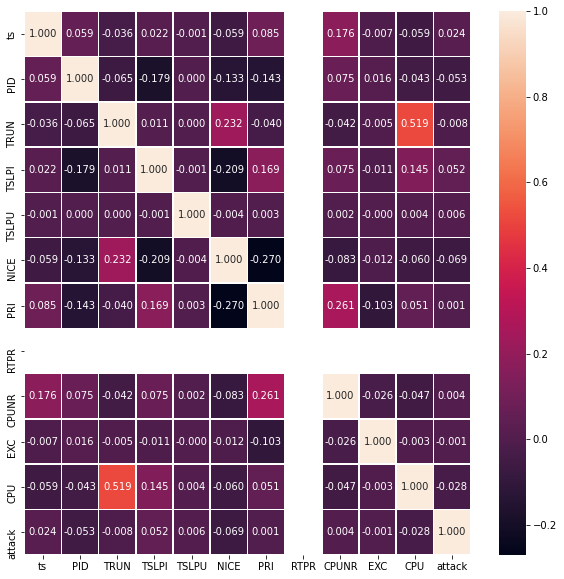

In [24]:
# correlation plot (heatmap) to show relationship between all the columns in a process activity
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(process_70.toPandas().corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)

The above heatmap shows the relationship between all the columns in the Process activity dataset by calculating the correlation coefficient between any two columns. From the graph, we can observe that RTPR does not carry anay insignificant information. Compared to the other columns, NICE is strongly correlated to attack. 

### 2. Feature extraction and ML training <a class="anchor" name="2"></a>

Feature Extraction is the process in which the initial set of raw data is reduced to optimal number of features which convey important, relevant and maximum information thereby reducing the computation costs and resources required. Feature extraction is one of the most important steps in Machine learning models which can help in fine tuning the model by eliminating redundant information that cause cluttering thereby increasing the efficiency of prediction models. While carrying out Feature extraction,  all the features are converted to label indexers and encoders as machine learning models are incapable of interpreting string values. The difference between feature selection and extraction is that selection is used to narrow down the number of features that are used to train the model and extraction is used to extract the information conveyed by both numeric and string data to numeric labels.

Using the results from exploratory analysis, we can carry feature selection by narrowing down the number of features to be used for model building as that would increase the model processing speeds.

#### 2.1 Preparing the training data and testing data <a class="anchor" name="2.1"></a>

1. Randomly split the dataset into 80% training data and 20% testing data for each use case

Given a dataset for model buillding, we can split it to first train the model for predictions and then use a part of it for testing the performance of the model. Here, we would be splitting in 80:20 training:testing set ratio.

In [25]:
# Using the randomsplit function, we will divide the dataset into two sets 
# and seed the random process to generate the same records
memory_train, memory_test = df_memory.randomSplit([0.8, 0.2], seed=2020)
process_train, process_test = df_process.randomSplit([0.8, 0.2], seed=2020)

In [26]:
# Count the records in training and test memory activity datasets
memory_train.groupBy("attack").count().show()
memory_test.groupBy("attack").count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 164365|
|     0|1435837|
+------+-------+

+------+------+
|attack| count|
+------+------+
|     1| 41258|
|     0|358540|
+------+------+



In [27]:
# Count the records in training and test process activity datasets
process_train.groupBy("attack").count().show()
process_test.groupBy("attack").count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 232984|
|     0|1309528|
+------+-------+

+------+------+
|attack| count|
+------+------+
|     1| 58380|
|     0|327076|
+------+------+



#### 2. With the class imbalance observed from 1.3.1, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1. Cache the rebalanced training data, and display the count of each event's data.

After splitting the activity datasets into 80:20 ratio, we should make sure that we have enough attack activity data to help us train the model in identifying events when the system is under attack. For this purpse, we would rebalance the training data for both memory and process activity in such a way that the training set has attacks in the ratio of 2:1.

In [28]:
# Using the randomsplit function, we will divide the dataset into two sets 
# and seed the random process to generate the same records
process_train_20,process_train_80 = process_train.randomSplit([0.2,0.8],seed=2020)
memory_train_20,memory_train_80 = memory_train.randomSplit([0.2,0.8],seed=2020)

In [29]:
# Code reference : https://stackoverflow.com/questions/53978683/how-to-undersampling-the-majority-class-using-pyspark
# this function has been used to carry out undersampling to emphasize on the attack data for training 
# the model to predict the attacks.

# Function Parameters: 
# 1. base-features: input dataset 
# 2. ratio: ratio in which the output data should be sampled. In our case, attack:non-attack ratio is 2:1
# 3. class_field: the label feature of the model to be predicted
# 4. base_class: desired category of the label feature. Here attack = 1 and normal = 0, 
# 1 is considered positive case and other negative

def undersample(base_features,ratio,class_field,base_class):
    pos = base_features.filter(col(class_field) == base_class)
    neg = base_features.filter(col(class_field) != base_class)
    total_pos = pos.count()
    total_neg = neg.count()
    fraction = float(total_pos * ratio)/float(total_neg)
    sampled = neg.sample(False,fraction)
    return sampled.union(pos)

In [30]:
# Rebalance the process data and cache it
process_rebalanced = undersample(process_train_20, 2, 'attack', 1)
process_rebalanced = process_rebalanced.cache()

In [31]:
# Rebalance the memory data and cache it
memory_rebalanced = undersample(memory_train_20, 2, 'attack', 1)
memory_rebalanced = memory_rebalanced.cache()

In [32]:
print('Count of records in the process rebalanced training data:', process_rebalanced.count())
print('Count of records in the memory rebalanced training data:', memory_rebalanced.count())

Count of records in the process rebalanced training data: 139829
Count of records in the memory rebalanced training data: 97779


In [33]:
process_rebalanced.groupby('attack').count().show()
memory_rebalanced.groupby('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|46536|
|     0|93293|
+------+-----+

+------+-----+
|attack|count|
+------+-----+
|     1|32738|
|     0|65041|
+------+-----+



In [34]:
# df_process.groupby('ts').count().orderBy('count',ascending = False).show(100000)
df_memory.groupby('ts').count().select('count').distinct().show()

+-----+
|count|
+-----+
|    1|
|    3|
|    2|
+-----+



### 2.2 Preparing features, labels and models <a class="anchor" name="2.2"></a>

#### 1. Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them.

Feature selection create a strong foundation for building an efficient ML model. It comprises of analysing all the features collected and choosing features that are best suited for the use case without missing or losing any important infomation that has a huge impact on the predictions. Good feature selection can reduce the computation costs significantly. Machine learning models are prone to errors and become more complicated if the dimensionality of the feature vectors increases thus reducing the overall quality of the system. 

* **Process Activity Feature selection and ML modeling:**

From the data exploratory analysis, it is observed that all the numeric columns and the string columns in the dataframe are correlated to each other. In this model our main aim is to predict whether the activity is attack or normal and are not interested in determining its type, we will exclude the type column during feature selection. All the values in RTPR column are Zero indicating that all the realtime priority processes hence we will excluded this feature as well. For any activity in the operating system, the timestamp  is a 13 digit Unix datetime format recorded in the logs data. Timestamp is an important feature if we are interested in carrying out time-series analysis. In this assignment, our goal is predict whether the system was attacked and not when the attack might take place. Some of the numeric columns have negative values, some are in the range below 5 but PID column as data in range of 4 digits. In comparison to the weights of the other features, PID would become the most important feature. But as we know, PID is a random process ID assigned to each activity for a particular session, we would have to scale these numeric values to normalize the weights of other numeric feature columns. Since ML models cannot interpret string labels, we will convert them to corresponding label indices based on their frequency of occurrence and in alphabetical order if frequency is the same. These values are then passed to one hot encoder feature extractor where the label indices generated in the previous step would be mapped to a binary vector to indicate its weighatage amonst all other feature values. The next step would be to assemble all the numeric and non-numeric columns into an array of vectors. As we know that some numeric values need to be scaled down, the feature vector array would under go Standard scaling feature extraction process. It is important that we get all the feature vectors into one as classifaction algorithms carry out prediction analysis only oon one column input.

* **Memory Activity Feature selection and ML modeling:**

From the data exploratory analysis, it is observed that VSIZE and RSIZE values range from negative to positive values in millions which gives distorted pattern. PID values are also one of the important feature whose values range from 0 to 4 digit values. For this purpose, we will be using Standard Scaler after all the feature vectors are rearranged in the form of an array. There is one String column CMD which records the command used to initiate the activity. All the steps mentioned above for process activity ML model would be used for Memory activity prediction model as well with StringIndexer and One Hot Encoding for CMD column to map the string values to label encoders and merge the numeric and non-numeric encoded features in the vector assembler. The next step would be to scale down the numeric values in the vector assembler vectors which are in the range of thousands and millions to avoid over shadowing of the other feature values.

In [35]:
# Since attack column is already excluded in the data exploratory step,
# the below array of numeric columns is used in further analysis without 'ts' and 'RTPR'
num_cols_process_selected = [x for x in num_cols_process if x != 'ts' and x != 'RTPR']
num_cols_memory_selected = [x for x in num_cols_memory if x != 'ts']

In [36]:
# All the string columns have been retained. 
# Display all the columns that would be used for processing
print("Process activity features:", num_cols_process_selected + cat_cols_process)
print("Memory activity features:", num_cols_memory_selected + cat_cols_memory)

Process activity features: ['PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU', 'POLI', 'Status', 'State', 'CMD']
Memory activity features: ['PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM', 'CMD']


### 2. Create Transformers / Estimators for transforming / assembling the features you selected above in 2.2.1

Below is the flow of how feature extraction would be carried on both the use cases to prepare the machine learning model for classification of prediction label 'attack'

1. `StringIndexer`: Map all the string features selected to label indices based on the frequency of occurrence
2. `OneHotEncoding`: Map the label indices into binary vectors for embedding the string values into the vector assembler
3. `Vector Assembler`: Combine all the numeric and non-numeric values into an array of feature values called feature vectors
4. `Standard Scaler`: This is used to scale down numeric values that can swamp the feature values with lower weightage.

In [37]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [38]:
# String Indexer input columns are categorical columns along with label column 'attack' 
# the output columns are label indices for the input columns
process_input_cols = cat_cols_process + ['attack']
process_output_indexer = [f'{x}_index' for x in process_input_cols] 

# String Indexer for process activity. 
# handleInvalid will gracefully handle any new string value found in any feature column while testing
process_indexer = StringIndexer(inputCols=process_input_cols, outputCols=process_output_indexer, handleInvalid='keep')

# One Hot Encoder input columns are output columns of String Indexer (index values)
# The output columns of OHE are vector columns of all the categorical columns
process_input_OHE = [x for x in process_output_indexer if x != 'attack_index']
process_output_OHE = [f'{x}_vec' for x in process_input_OHE]

# One Hot Encoder for process activity
process_encoder = OneHotEncoder(inputCols=process_input_OHE, outputCols=process_output_OHE)

# Vector Assembler generates a vector of all the columns in the process activity
process_input_assembler = process_output_OHE + num_cols_process_selected

# The outpur of vector assembler is a single column 'features' with all values stored in an array
process_assembler = VectorAssembler(inputCols=process_input_assembler, outputCol='features')

# Standard Scaler is used to scale down the values that belong to higher range of numeric values.
# 'features' column is fed as input to the Standard Scaler model and the ouput generated is stored in 'ScaledFeatures'
process_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [39]:
# String Indexer input columns are categorical columns along with label column 'attack' 
# the output columns are label indices for the input columns
memory_input_cols = cat_cols_memory + ['attack']
memory_output_indexer = [f'{x}_index' for x in memory_input_cols] 

# String Indexer for memory activity
# handleInvalid will gracefully handle any new string value found in any feature column while testing
memory_indexer = StringIndexer(inputCols=memory_input_cols, outputCols=memory_output_indexer, handleInvalid='keep')

# One Hot Encoder input columns are output columns of String Indexer (index values)
# The output columns of OHE are vector columns of all the categorical columns
memory_input_OHE = [x for x in memory_output_indexer if x != 'attack_index']
memory_output_OHE = [f'{x}_vec' for x in memory_input_OHE]

# One Hot Encoder for process activity
memory_encoder = OneHotEncoder(inputCols=memory_input_OHE, outputCols=memory_output_OHE)

# Vector Assembler generates a vector of all the columns in the memory activity
memory_columns = memory_output_OHE + num_cols_memory_selected

# The outpur of vector assembler is a single column 'features' with all values stored in an array
memory_assembler = VectorAssembler(inputCols=memory_columns, outputCol='features')

# Standard Scaler is used to scale down the values that belong to higher range of numeric values.
# 'features' column is fed as input to the Standard Scaler model and the ouput generated is stored in 'ScaledFeatures'
memory_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

#### 3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for both the use cases

The label to be predict is in binary label with classification groups known to us. Therefore, we would be using supervised learning estimators called classification algorithms to complete our ML model for identifying system attacks. Supervised learning is a technique of training a model based on the input-output data examples fed to it. The algorithm has to analyse how the input has been classified based on the given training data set with classified labels to predict any test data set for their predictions. 

In this assignment, we would be using two such classification algorithms - Decision Tree and Gradient Boosted Tree to classify the both process and memory activities into normal activities or system attack. Both of these algorithms used tree-based model approach.

Decision Tree supervised learning model is tree based model based on conditions tested at each node of the tree and then split into two separate nodes based on the decision made called target which are predefined classes. It basically tries to find the relation between independent and dependednt variables to train the ML model to predict target outcomes. Decision Trees can easily be generalized if we do not regularize the tree building parameters like maximum depth upto which it can iterate. 

Gradient Boosted Tree works on the principle of making the model stronger sequentially by leveraging the residuals and strengthening the weak prediction models. GBM is called an essemble model as the final product is amalgamation of various indivdual models with weak prediction power but on combining all the individual models, the final model becomes more stronger in predicting new classes using knowledge of predefined classes. GBT is typically a low variance and high bias model (tends to overfit).

In [40]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml import Pipeline

In [41]:
# Create a decision tree and gradient boosting tree classifier for process activity
# Decision Tree will will build a tree with max depth = 10
# Output from the standard scaler is fed as input to the decision tree
process_decisiontree = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack_index', maxDepth = 10)

# Gradient Boosting Classifier will generate maximum number of iterations (trees) = 20 for model training
# Output from the standard scaler is fed as input to the GBT
process_gbt = GBTClassifier(labelCol="attack_index", featuresCol='scaledFeatures', maxIter=20)

In [42]:
# Create a decision tree and gradient boosting tree classifier for memory activity
# Decision Tree will will build a tree with max depth = 10
# Output from the standard scaler is fed as input to the decision tree
memory_decisiontree = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack_index', maxDepth = 10)

# Gradient Boosting Classifier will generate maximum number of iterations (trees) = 20 for model training
# Output from the standard scaler is fed as input to the GBT
memory_gbt = GBTClassifier(labelCol="attack_index", featuresCol="scaledFeatures", maxIter=20)

In [43]:
# Create separate pipeline model for two different classifiers for process activity model
pipeline_process_dt = Pipeline(stages = [process_indexer,process_encoder,process_assembler, 
                                         process_scaler,process_decisiontree])
pipeline_process_gbt = Pipeline(stages = [process_indexer,process_encoder,process_assembler,process_scaler,process_gbt])

In [44]:
# Create separate pipeline model for two different classifiers for memory activity model
pipeline_memory_dt = Pipeline(stages = [memory_indexer,memory_encoder,memory_assembler,memory_scaler,memory_decisiontree])
pipeline_memory_gbt = Pipeline(stages = [memory_indexer,memory_encoder,memory_assembler,memory_scaler,memory_gbt])

### 2.3 Training and evaluating models <a class="anchor" name="2.3"></a>

#### 1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2

Using the rebalanced data created for each use case, train models with the pipeline designed for classification.

In [45]:
# Using the fit function in the pipeline class to train the models with available datasets
# Decision tree pipeline to train the process model
pipelineModel_process_dt = pipeline_process_dt.fit(process_rebalanced)
# GBM pipeline to train the process model
pipelineModel_process_gbt = pipeline_process_gbt.fit(process_rebalanced)

In [46]:
# Using the fit function in the pipeline class to train the models with available datasets
# Decision tree pipeline to train the memory model
pipelineModel_memory_dt = pipeline_memory_dt.fit(memory_rebalanced)
# GBM pipeline to train the memory model
pipelineModel_memory_gbt = pipeline_memory_gbt.fit(memory_rebalanced)

#### 2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label

After the model with two different classifiers is trained, we will test the model on the test dataset using the transform() function defined in the pipeline class. The resulting dataframes will have prediction column for all the test activities provided in the test datasets for each estimator.

In [47]:
# Predictions generated on test dataset for Process activity model
# Decision Tree predictions
predictions_process_dt = pipelineModel_process_dt.transform(process_test)

# GBM predictions
predictions_process_gbt = pipelineModel_process_gbt.transform(process_test)

In [48]:
# Predictions generated on test dataset for Process activity model
# Decision Tree predictions
predictions_memory_dt = pipelineModel_memory_dt.transform(memory_test)

# GBM predictions
predictions_memory_gbt = pipelineModel_memory_gbt.transform(memory_test)

In [49]:
# The attack_index generated in the String Indexer stage is the category label that we have to predict. 
# Renaming it to label to simplify observations
predictions_process_dt = predictions_process_dt.withColumnRenamed('attack_index','label')
predictions_process_gbt = predictions_process_gbt.withColumnRenamed('attack_index','label')
predictions_memory_dt = predictions_memory_dt.withColumnRenamed('attack_index','label')
predictions_memory_gbt = predictions_memory_gbt.withColumnRenamed('attack_index','label')

In [50]:
# Count the number of records predicted as attack or normal activity based on the label data in the test dataset
predictions_process_dt.groupby('label','prediction').count().show()
predictions_process_gbt.groupby('label','prediction').count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 30509|
|  0.0|       1.0| 40924|
|  1.0|       0.0| 27871|
|  0.0|       0.0|286152|
+-----+----------+------+

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 28799|
|  0.0|       1.0| 39984|
|  1.0|       0.0| 29581|
|  0.0|       0.0|287092|
+-----+----------+------+



In [51]:
# Count the number of records predicted as attack or normal activity based on the label data in the test dataset
predictions_memory_dt.groupby('label','prediction').count().show()
predictions_memory_gbt.groupby('label','prediction').count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 27925|
|  0.0|       1.0| 60313|
|  1.0|       0.0| 13333|
|  0.0|       0.0|298227|
+-----+----------+------+

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 22871|
|  0.0|       1.0| 37507|
|  1.0|       0.0| 18387|
|  0.0|       0.0|321033|
+-----+----------+------+



#### 3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

Whenever a prediction model is tested, it will provide two important features for each record: `Probability` and `Prediction`.
Probability will be represented as a vector of postive and negative probability of the data record to be predicted as postive category or negative category in a binary classifier.

One the most important features in machine learning modelling is to evaluate the performance parameters of the model and mathematically find how efficiently the model can identify legit attack activities. Most of the performance paramter calculations are based on the concept of confusion matrix. Confusion matrix has the count of records from the test data belonging to the following conditions:

1. True Positive: When the positive label is predicted positively.
2. True Negative: When the positive label is predicted negatively.
3. False Positive: When the negative label is predicted positively.
4. False Negative: When the negative label is predicted negatively.

For this purpose, we will be using 4 performance paramters: 

1. `AUC (Area under the curve)` : AUC of a binary classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. The area under the curve is found by calculating the True Positive Rate and False Positive Rate for different probability thresholds ranging between 0-1.
2. `Accuracy` : Accuracy of a system is defined as the number of correct predictions made frome all the input samples. Here we will use the True Negative count upon total number of records to find the accuracy.
3. `Recall` : Recall of a system is defined the ratio of true positive records to the total number of correct predictions.
4. `Precision` : Precision is number of True Positive results divided by the number of positive results predicted by the classifier.

The ML model that we have built should be capable of predicting when an attack happens accurately and not give false alarms. Recall and precision are two such metrics that give insights of the system efficiency in identifying correct classes.
But AUC metrics considers both these conditions by calculating the Sensitivity and Specificity of the system. The Recieving Operating Curve(ROC) is plot of Sensitivity (True Positive Rate) to Specificity(False Positive Rate) under different thresholds of probability and AUC is the area under the curve. AUC would be better metric to measure the model performance in a binary classification model as it shows the ability to differentiate between classes. Higher the AUC, better is the model. Values below 0.5 can show that the model is underfitted showing that it cannot distinguish between classes. Value close to 1 is considered to be a better model but that also shows that the model is overfitted.

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [53]:
# MulticlassClassificationEvaluator is an evaluation package in pyspark.ml 
# to find the accuracy of a model using the prediction and label data of the model
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')

# BinaryClassificationEvaluator is an evaluation class in pyspark.ml which is used to find the AUC 
binary_class_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='label')

In [54]:
# UDF to compute performance metrics of a prediction model
# MulticlassMetrics is an evaluation class in pyspark mlib to find precision of the model
# the input to MulticlassMetrics is the value of the label which is considered as positive in the prediction model
def compute_metrics(predictions):
    predictions_metrics = predictions.select('prediction','label').rdd
    metrics_evaluator = MulticlassMetrics(predictions_metrics)
    print("AUC: " ,binary_class_evaluator.evaluate(predictions))
    print("Accuracy:" ,evaluator.evaluate(predictions))
    print("Precision: " ,metrics_evaluator.precision(1.0))
    print("Recall: ", metrics_evaluator.recall(1.0))

In [55]:
print("Process activity predictions: ")
print("A. Using Decision Tree:")
compute_metrics(predictions_process_dt)
print("B. Using Gradient Boosting Tree:")
compute_metrics(predictions_process_gbt)

Process activity predictions: 
A. Using Decision Tree:
AUC:  0.5662014584438902
Accuracy: 0.8215230791581919
Precision:  0.42709951982977057
Recall:  0.522593353888318
B. Using Gradient Boosting Tree:
AUC:  0.8196668483589986
Accuracy: 0.8195254451869993
Precision:  0.4186935725397264
Recall:  0.4933025008564577


In [56]:
print("Memory activity predictions: ")
print("A. Using Decision Tree:")
compute_metrics(predictions_memory_dt)
print("B. Using Gradient Boosting Tree:")
compute_metrics(predictions_memory_gbt)

Memory activity predictions: 
A. Using Decision Tree:
AUC:  0.6699772401123508
Accuracy: 0.8157919749473485
Precision:  0.3164736281420703
Recall:  0.676838431334529
B. Using Gradient Boosting Tree:
AUC:  0.8661433070029568
Accuracy: 0.8601943981710763
Precision:  0.3787969127828017
Recall:  0.5543409762955063


#### 4. Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model. And visualise the ROC curve for the better model you selected for each use case.

In [57]:
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T
import matplotlib.pyplot as plt

In [58]:
# In this function, we would extract all the important features in a ML model by using the metadata contents of each model.
# For each model, the features are ranked(scored) based on the information that it conveys and then rank them in decreasing 
# order of their scores. This function will return all the feature values in decreasing order of their ranks 

# Reference : https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [59]:
# This function will pass the ML model features metadata according to their importance used for predictions.
# The top 5 features for a model are predicted
def compute_important_features(pipeline_model, predictions):
    imp = pipeline_model.stages[-1].featureImportances
    print(ExtractFeatureImp(imp, predictions, "features").head(5))

In [60]:
compute_important_features(pipelineModel_memory_dt,predictions_memory_dt)
compute_important_features(pipelineModel_memory_gbt,predictions_memory_gbt)

    idx                   name     score
0   419                    PID  0.260127
4   423                  VSIZE  0.181063
10    1  CMD_index_vec_apache2  0.151017
5   424                  RSIZE  0.142537
7   426                  RGROW  0.083316
   idx    name     score
0  419     PID  0.294595
4  423   VSIZE  0.184236
5  424   RSIZE  0.167331
1  420  MINFLT  0.106103
3  422  VSTEXT  0.047086


**Top Features in Memory activity model:**

In both the binary classification models, we can see that PID feature ranks the highest indicating that eeven if every memory activity will have a unique PID in session, these can be repeatedly used in different session intervals and always occur within a range of 4 digit values (Some PID values have dedicated processes and so most PIDs are reused). The other important features identifies are VSIZE and RSIZE as they convey a lot of information regarding how the process uses the virtual and residential memory to execute a process. Similarly RSIZE and VSIZE indicate the rate at which the memory usage in both virtual and residential memory usage grows. The CMD command 'apache2' has most frequently been used in times of attacks. 

**Better Machine Learning Model for predicting attacks in a Process activity**

From the performance metrics values and the important features identified in the process activity, Gradient Boosting Tree model seems to give better results compared to Decision Tree as the AUC is higher in GBM compared to Decision Tree. The values of accuracy, recall and presion are quite close.


**Discussion about ts feature:**

'ts' is a feature commonly used in both the use cases as every log captured by the operating system. This feature can overshadow the importance and information conveyed by other features. 'ts' is the 13 digit value used to indicate Unix timestamp. On observing the trend of frequncy of each time stamp in the dataets, it can be since that they occur between counts 1-4 indicating that at least one process is running at a time in the system. Since we are not interested in time-series analysis of identifying WHEN an attack will take place, 'ts' is not an important feature but rather how the system behaves when an attack takes place is more important. In time series analysis, this timestamp could have helped us in predict the when an attack is likely to happen.


In [61]:
compute_important_features(pipelineModel_process_dt,predictions_process_dt)
compute_important_features(pipelineModel_process_gbt,predictions_process_gbt)

    idx                name     score
0   447                 PID  0.419480
12    3  Status_index_vec_-  0.222019
2   449               TSLPI  0.059143
23   14  CMD_index_vec_atop  0.039685
6   453               CPUNR  0.038644
    idx                name     score
0   447                 PID  0.460990
12    3  Status_index_vec_-  0.071981
2   449               TSLPI  0.051524
4   451                NICE  0.043972
6   453               CPUNR  0.043372


**Top Features in the Process activity:**

Similar to the Memory activity, PID is identified as the most important feature along with CMD command 'apache2' being used most frequently. There are a lot of records with no status. Most of the processes are in uninterruptible state. The number of processors that a process uses is also acknowledged as being important.

**Better Machine Learning Model for predicting attacks in a Process activity**

From the performance metrics and important features found, Gradient Boosting Tree seems to be a better model compared to Decision Tree as the AUC value is much higher for GBM compared to Decision Tree. As this dataset deals with a lot of non-numeric data, the accuracy of Decision tree is quite less.

#### Plot ROC curves for better models

In [111]:
# Every Binary classifier will generate a probability column which is vector of positive and negative probability.
# We are interested in only the positive probability values and so we split the probability column to postive 
# and negative probability. 
# We can use this probability value to plot the ROC curve by comparing it against a range of threshold values.
def split_probability(predictions):
    to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
    predictions = predictions.withColumn('probability', to_array('probability'))
    predictions = predictions.select(predictions.probability[0].alias('negative_prob'),
                                     predictions.probability[1].alias('positive_prob'),'label')
    return predictions

In [112]:
# Function to plot the ROC curve using matplotlib.pyplot function to plot tpr vs fpr values for different thresholds
def roc_curve_plot(tpr,fpr):
    plt.plot(fpr,tpr)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

In [113]:
def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    return TP,TN,FP,FN

In [114]:
# Generate all the values in the confusion matrix. MulticlassMetrics can work with rdd datasets
        # predictions_metrics = predictions_process_gbt.select('prediction','label').rdd
        # metrics_evaluator = MulticlassMetrics(predictions_metrics)
        # metrics = metrics_evaluator.confusionMatrix().toArray()
        # read all confusion matrix elements
        # tn = metrics[0][0]
        # fp = metrics[0][1]
        # fn = metrics[1][0]
        # tp = metrics[1][1]
        # list of all true positive rate and false positive rate values to be plotted

In [128]:
# In this function we would generate the confusion matrix as defined above to generate an array of 10 values of tpr and fpr 
# These values would be found for different thresholds ranging from 0-1 in steps of 0.1 
# and compared to positive probability values.
def roc_curve(predictions):
    predictions = split_probability(predictions)
    tpr = []
    fpr = []
    for threshold in range(0, 11, 1):
        threshold = threshold/10.0
        predictions=predictions.withColumn('prediction',F.when(predictions.positive_prob > threshold,1.0).otherwise(0.0))
        # Using the multiclassmetric package to find the confusion matrix. 
        # the input dataset should be an rdd with positive activity as 1
        predictions_metrics = predictions.select('prediction','label').rdd
        metrics_evaluator = MulticlassMetrics(predictions_metrics)
        # output is a dense matrix
        metrics = metrics_evaluator.confusionMatrix().toArray()
        # read all confusion matrix elements
        tn = metrics[0][0]
        fp = metrics[0][1]
        fn = metrics[1][0]
        tp = metrics[1][1]
        # list of all true positive rate and false positive rate values to be plotted
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
    return tpr,fpr

ROC curve for Gradient Boosting Model for Process Activity


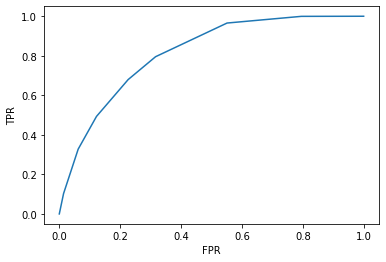

In [129]:
print("ROC curve for Gradient Boosting Model for Process Activity")
tpr,fpr = roc_curve(predictions_process_gbt)
roc_curve_plot(tpr,fpr)

ROC curve for Gradient Boosting Model for Memory Activity


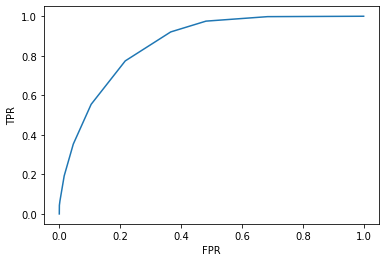

In [130]:
print("ROC curve for Gradient Boosting Model for Memory Activity")
tpr,fpr = roc_curve(predictions_memory_gbt)
roc_curve_plot(tpr,fpr)

####  5. Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.

In [86]:
# Here we would be using the remaining 80% of dataset left while created the rebalanced data 
# used for training the model to save the model ofr future reference
# Sample the process model with attacks:normal activities in 2:1 ratio
process_rebalanced_2 = undersample(process_train_80, 2, 'attack', 1)
process_rebalanced_2 = process_rebalanced_2.cache()

In [87]:
# Sample the memory model with attacks:normal activities in 2:1 ratio
memory_rebalanced_2 = undersample(memory_train_80, 2, 'attack', 1)
memory_rebalanced_2 = memory_rebalanced_2.cache()

In [88]:
# Train the best model selected with the new rebalanced dataset 
pipelineModel_process_gbt_2 = pipeline_process_gbt.fit(process_rebalanced_2)
pipelineModel_memory_gbt_2 = pipeline_memory_gbt.fit(memory_rebalanced_2)

In [89]:
# Persist the model using the save() function
pipelineModel_process_gbt_2.save('Linux_attack_process_prediction_model')

In [90]:
pipelineModel_memory_gbt_2.save('Linux_attack_memory_prediction_model')

In [131]:
sc.stop()

## 3. Knowledge Sharing <a class="anchor" name="3"></a>

K-Means is a type of unsupervised learning algorithm where we assign a target label to different clusters with similar characteristics. KMeans is also called a clustering alagorithm. While training the clustering model, the training dataset is divided into _k_ number of clusters with randomly initialized _k_ centroids. Centroids are basically prototype of all the examples within a dataset which can be used to represent the characteristics possessed by a cluster. The model will train itself by first finding the distance between the feature vector of various records in the dataset with the _k_ centroids. The pair with the lowest distance is selected and the data record is assigned to a new cluster if the centroid belongs to a different cluster. After each iteration, new _k_ centroids for each cluster are calculated. The model converges when the distance between all the elements within a close proximity. Distance between the feature vector and centroid is calculated using Eucliden distance. 

In this assignment, we are using Spark engine to build out machine learning models. Spark UI helps us in observing how the engine performs the Kmeans algorithm for the dataset provided below 

In [132]:
# Import SparkConf, SparkSession and SparkContext classes for Spark Session setup and Spark SQL 
# operations for further analysis
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark import SparkContext #Spark

# Run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"

# Set the name for Spark application
app_name = "K-Means Test"

# Setup configuration parameters for Spark Session
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [133]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

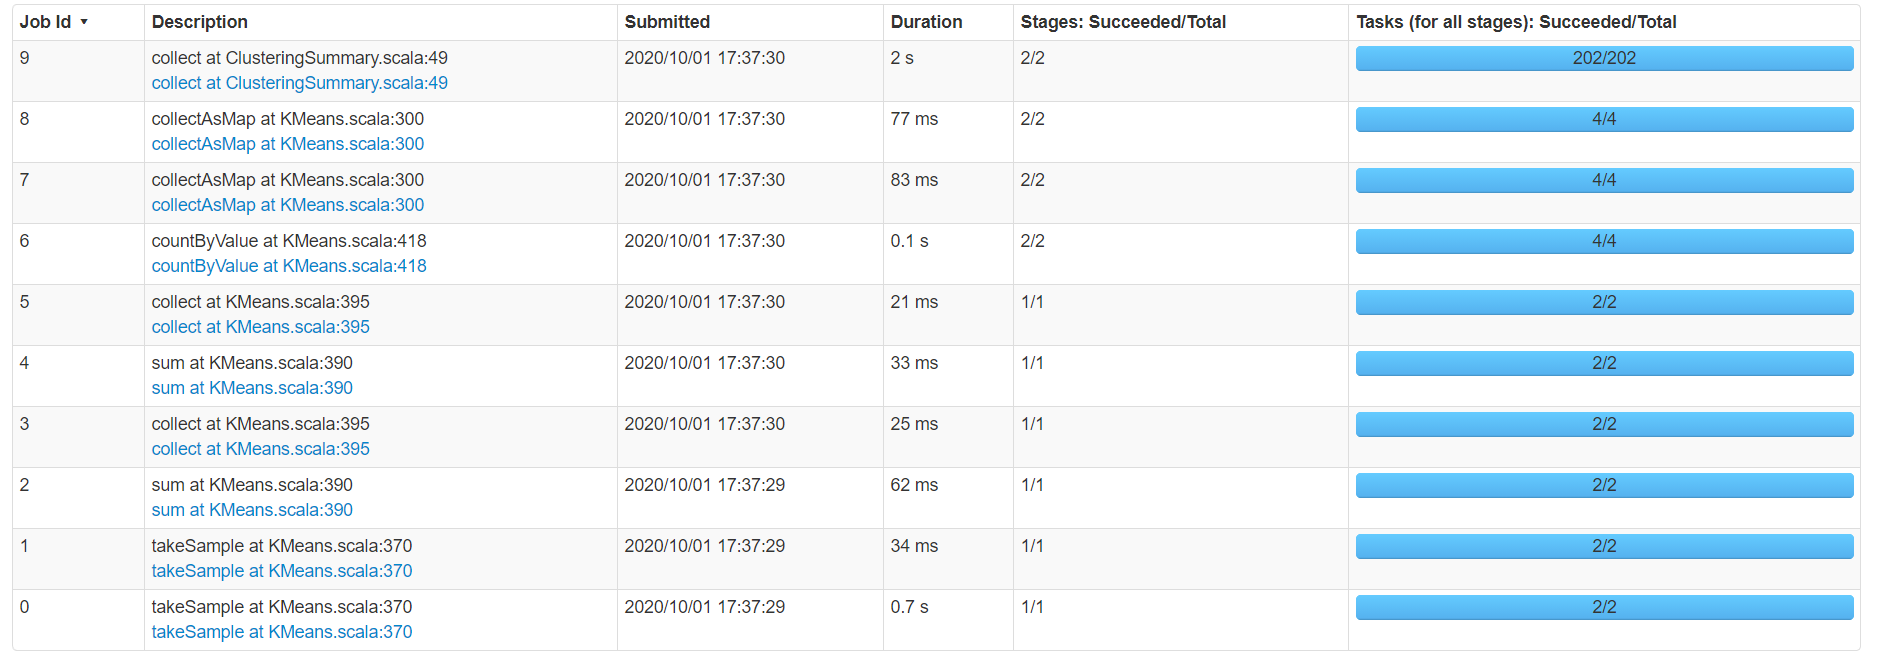

KMeans algorithm has been written in pyspark.mlib.clustering package to cluster unlabelled categorical data in Spark engine. The algorithm has been written in Kmeans.scala class. A new job is created every time Kmeans calls a rdd or spark sql function to perform pyspark functions. In the first two jobs, the provided data set is divided into two partitions by spark has been read and the vector assembled dataset is randomly divided into _k=3_ clusters. This random split is done without replacement and new centroids are found for each cluster. In the next stages sum and collect, the first iteration begins where the centroids are broadcasted to every cluster data point. Here the rdd sum function is called to find the Euclidean distance between the data vectors and the centroids. Eucliden distance i.e. cost is calculated wrt to the three centroids and the minimum distance amongst the three are stored with their corresponding data vector rdd and zip mapped together to be written in the main memory(disk). The same steps are repeated for the second partition data. In the countByValue stage, the new cluster centroid is found for every cluster by using the mapped rdd generated for each cluster. In the collectByMap stage, weight of each cluster is found to find the new centroid using the weighted average method. In the final stage, ClusteringSummary.scala is class is called. Here the prediction column is used as label to define the cluster members and the centroid. KMeans algorithm follows result parallelism in this model. Since the number of max iterations for this KMeans algorithm is not defined, the default number of iterations that the mdel would undergo is 20. The default number of clusters generated are 2 and the user defined clusters cannot be less than 1. The model converges when no new centroids are found.

Thank You. 